# Analysis of PN emission lines of CTIO Data in January 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- affiliation : LAL/IN2P3/CNRS France
- date   : January 19th 2017
- update : January 25 2017

The goal is to calibrate in wavelength the X axis.
For this the raw spectra in the dat are read as well as the spectra simulated.
The simulated may have been checked by View_SimSpectrum_XX.ipynb

In [8]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [9]:
print theNotebook

AnalysisEmissionLines_HEN2_5


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [11]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [12]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [13]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [14]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [15]:
%load_ext Cython

In [16]:
from IPython.display import Image, display

In [17]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [18]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [19]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [20]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

### Calibration in wavelength

In [21]:
cal_object_name='HD14943'
cal_date_name='2017_01_17'
simspectracalibresult='SpecCalibFitResults_'+cal_object_name+'_'+cal_date_name +'.fits'

In [22]:
def GetCalib(fitparam):
    SIZE=len(fitparam)
    for index in np.arange(SIZE):
        if index == 0:
            fitparam_mean=fitparam[index]
        else:
            fitparam_mean+=fitparam[index]
    fitparam_mean/=float(SIZE)
    return fitparam_mean

### the Fit order

In [23]:
FIT_ORDER=2

## Read the calibration data

In [24]:
hdu_list=fits.open(simspectracalibresult)
hdu_list.info()

Filename: SpecCalibFitResults_HD14943_2017_01_17.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       7   ()      
  1              ImageHDU         7   (3, 104)   float64   
  2              ImageHDU         7   (3, 104)   float64   


In [25]:
print hdu_list[0].header

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  ANALYST = 'Sylvie Dagoret-Campagne'                                             OBJ-NAME= 'HD14943 '                                                            COMMENT Fits straight line on spectra                                           END                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [26]:
fitparam_rightspectra=hdu_list[1].data
fitparam_leftspectra=hdu_list[2].data

In [27]:
fitparam=GetCalib(fitparam_rightspectra)

In [28]:
print fitparam

[ -3.08122762e-04   1.32237608e+00  -4.76682373e+01]


In [99]:
fitcalibcurve=np.poly1d(fitparam)  # pixel to wavelength

## Output directory for images generated in the notebook view (not true fits images)

In [29]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [30]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

- Left and Right spectra in the data

In [31]:
inputdir="./spectrum_fitsspec"
object_name='HEN_2_5'

## Location of corrected images
----------------------------------

In [32]:
input_filelist=os.listdir(inputdir) 

In [33]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [34]:
print input_filelist[0:5]

['finalSpectra_HEN2_5_20170119_507.fits'
 'finalSpectra_HEN2_5_20170119_508.fits'
 'finalSpectra_HEN2_5_20170119_509.fits'
 'finalSpectra_HEN2_5_20170119_510.fits'
 'finalSpectra_HEN2_5_20170119_511.fits']


In [35]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [36]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0


    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall('^finalSpectra_HEN2_5_20170119_([0-9]+).fits',file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages    
    

In [37]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [38]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [39]:
print indexes_files

[507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523]


In [40]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [41]:
sorted_numbers=indexes_files[sorted_indexes]

In [42]:
print sorted_indexes

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [43]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [44]:
Focus = [12000,12050,12100,12150,12150,12200,12250,12300,12350,12400,12450,12500,12550,12600,12650,12700,12750]

In [45]:
len(Focus)

17

Image #507, focus=12000
Image #508, focus=12050
Image #509, focus=12100
Image #510, focus=12150 -> Manipulation error. Use the next and suppress this one.
Image #511, focus=12150
Image #512, focus=12200
Image #513, focus=12250 -> I see that the PSF of the PN is wider than stars; spectral lines are elongated in lambda.
Image #514, focus=12300 -> seeing monitor 1.4
Image #515, focus=12350 -> looks like "normal" focus for stars (seeing~1.4" like monitor)
Image #516, focus=12400
Image #517, focus=12450
Image #518, focus=12500
Image #519, focus=12550 -> airmass 1.66
Image #520, focus=12600 -> Le soleil arrive... Le fond monte
Image #521, focus=12650
Image #522, focus=12700
Image #523, focus=12750


In [46]:
X=[4102, 4340, 4363, 4388,4472, 4861, 4922, 4959, 5007, 5518,5538, 5754,5876, 6548, 6563,6584, 6678, 6716,6731,7065,7136,7325]
Y=[20.7, 39.6, 2.7, 0.3, 4.6, 100.,1.3, 193.9, 605.0, 0.3, 0.5,0.7,17.4,0.,650., 47.5,5.2,1.,1.9,8.9,13.3,11.]

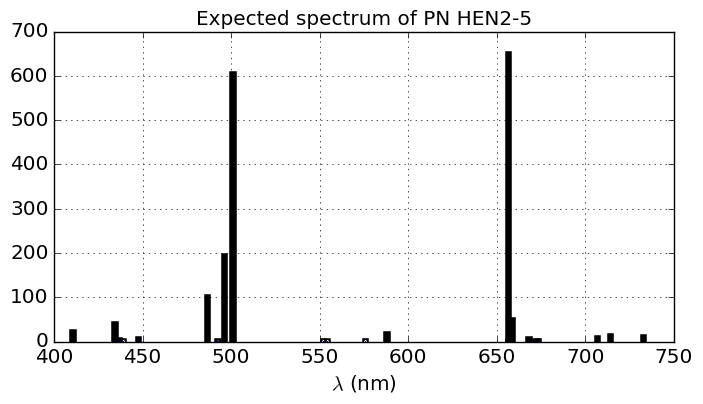

In [47]:
WL=np.array(X)/10.
plt.figure(figsize=(8,4))
plt.grid()
plt.bar(WL,Y,lw=4)
plt.xlabel('$\lambda$ (nm)')
plt.title('Expected spectrum of PN HEN2-5')

## Build full filename
----------------------------

In [48]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [49]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [50]:
print sorted_filenames.shape

(17,)


## Acces to spectrum data
----------------------------------

In [51]:
all_dates = []
all_airmass = []
all_spectra = []
all_titles = []
all_header = []
all_img = []

In [52]:
%%cython

import numpy as np
from astropy.io import fits

def BuildRawSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_spectra = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        the_spectrum=table_data.field('Spectrum')
 
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_spectra.append(the_spectrum)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_spectra

In [53]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_spectra=BuildRawSpec(sorted_files,sorted_numbers,object_name)

## Show Spectra
-----------------------

In [54]:
len(all_spectra)

17

In [55]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os


def ShowSpectra(all_spectra,all_titles,object_name,dir_top_images,figname):
    """
    ShowSpectra: 
    ==============
    """
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/2)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,2,figsize=(25,25))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%2
        iy=index/2
        spectrum=all_spectra[index]
        axarr[iy,ix].plot(spectrum,'r-',lw=2)
        axarr[iy,ix].set_title(all_titles[index])
        #axarr[iy,ix].set_ylim(0.,200.)
        #axarr[iy,ix].set_xlim(0.,500.)
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0,20000.)
        axarr[iy,ix].set_xlim(0,1500.)
    
    title='spectra in the band'
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,figname)
    plt.savefig(figfilename)

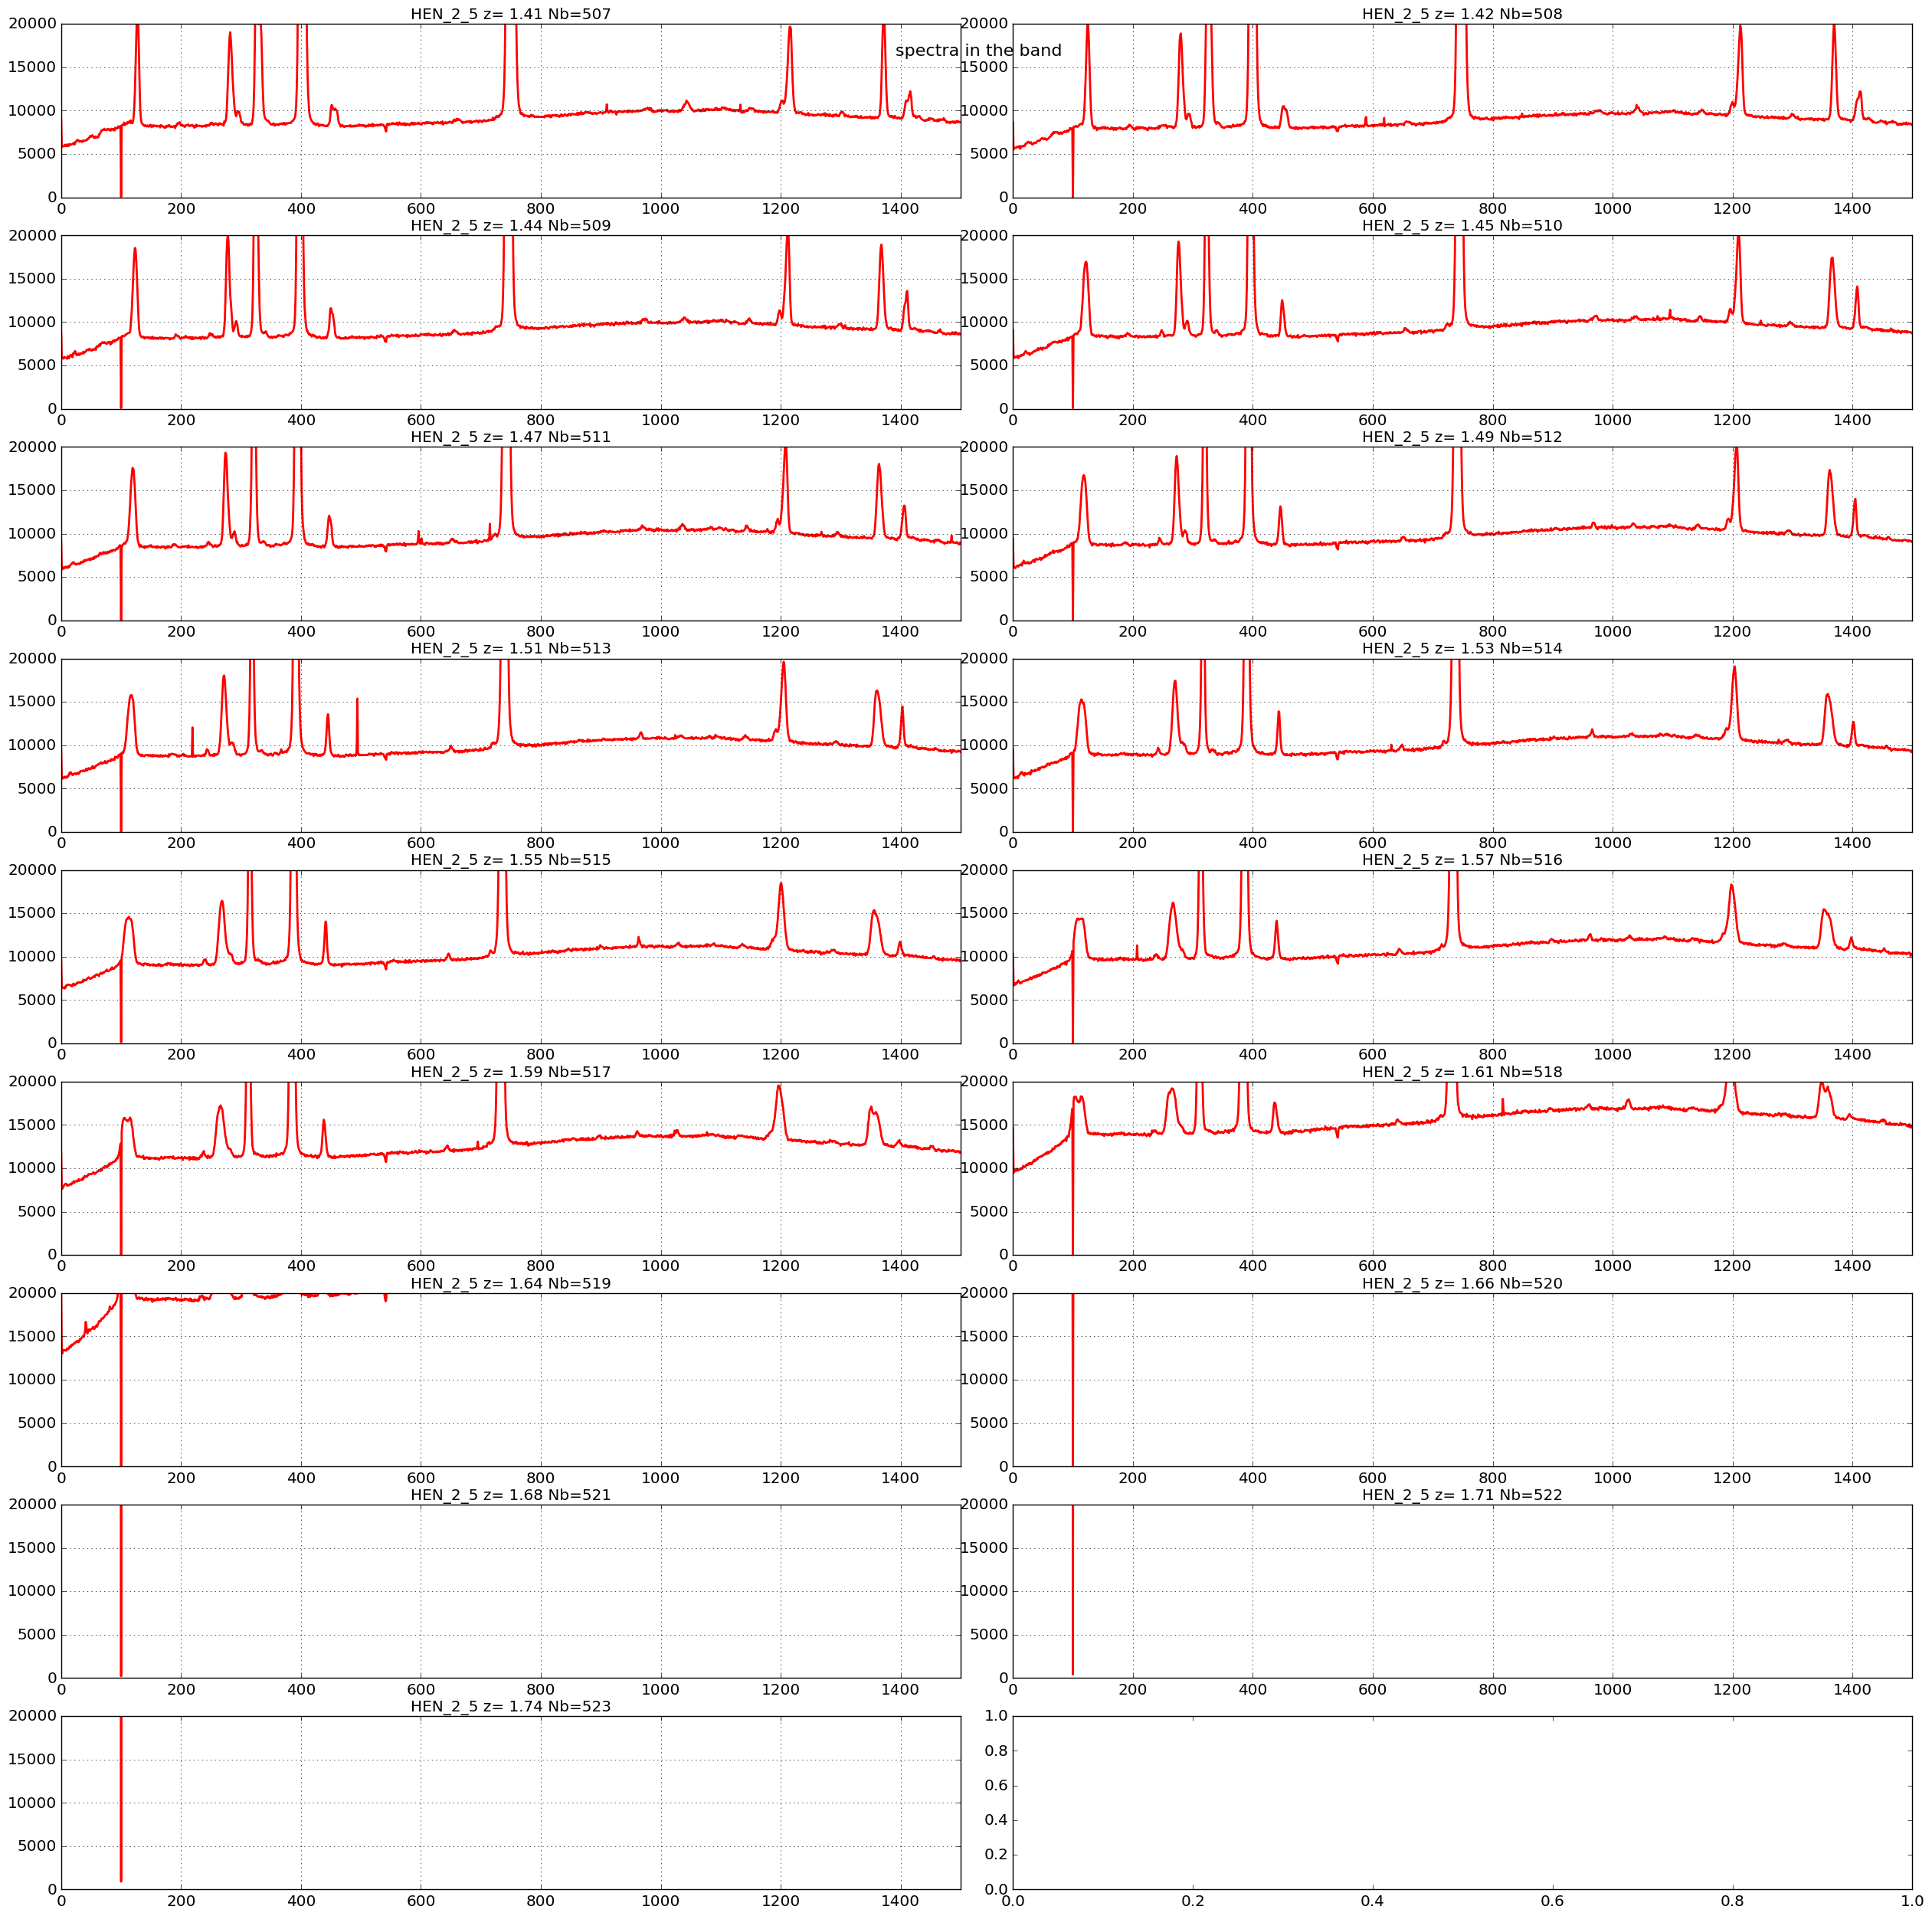

In [56]:
ShowSpectra(all_spectra,all_titles,object_name,dir_top_images,'allspectra.pdf')

## Calibrate in wavelength

In [79]:
sel=0

In [91]:
spectrum_cut=all_spectra[sel][0:1500]

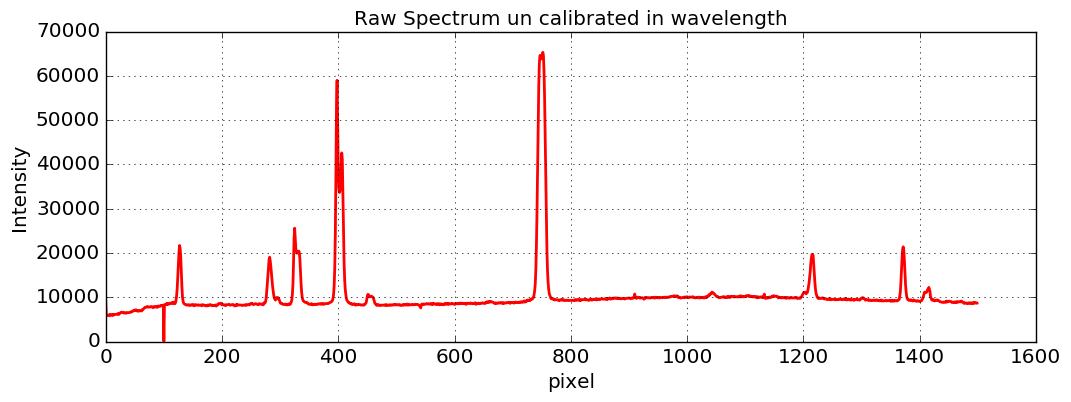

In [123]:
plt.figure(figsize=(12,4))
plt.plot(spectrum_cut,'r-',lw=2)
#plt.xlim(0,1500)
plt.ylim(0,70000.)
plt.grid(True)
plt.xlabel('pixel')
plt.ylabel('Intensity')
plt.title('Raw Spectrum un calibrated in wavelength')

In [93]:
NBBINS=len(spectrum_cut)

In [104]:
print NBBINS

1500


In [94]:
index_max=np.where(spectrum_cut==spectrum_cut.max())

In [105]:
print index_max

(array([752]),)


In [106]:
pixel_shift=np.arange(NBBINS)-index_max[0]

In [107]:
pixel_shift

array([-752, -751, -750, ...,  745,  746,  747])

In [108]:
print len(pixel_shift)

1500


In [115]:
wavelengths=np.where(pixel_shift>0,fitcalibcurve(pixel_shift), -fitcalibcurve(-pixel_shift))

In [117]:
wavelengths.shape[0]

1500

In [ ]:
spectrum_cut

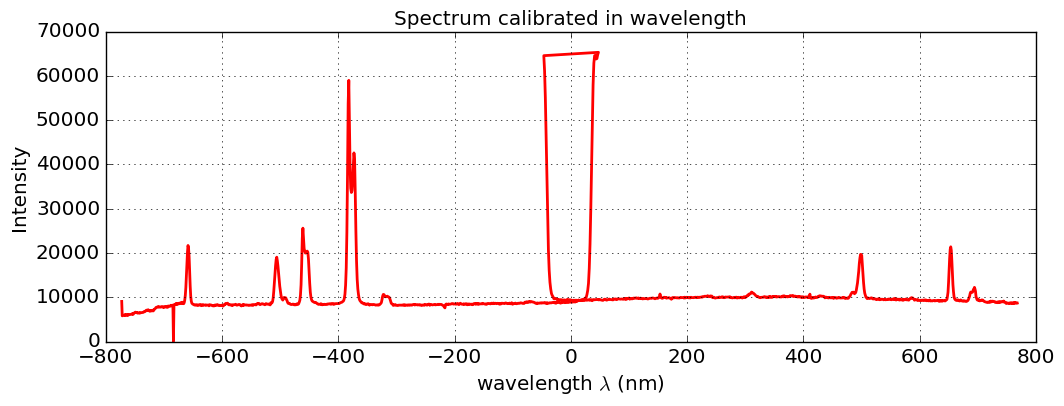

In [121]:
plt.figure(figsize=(12,4))
plt.plot(wavelengths,spectrum_cut,'r-',lw=2)
#plt.xlim(0,1500)
plt.ylim(0,70000.)
plt.grid(True)
plt.xlabel('wavelength $\lambda$ (nm)')
plt.ylabel('Intensity')
plt.title('Spectrum calibrated in wavelength')

## Selection in pixel frame

In [57]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os


def SelectLines(all_spectra,all_titles,object_name,dir_top_images,figname):
    """
    CutLines: 
    ==============
    """
    YMAX=40000.
    YMIN=0
    
    X1=105
    X2=150
    X3=250
    X4=295
    

    X5=710
    X6=780
    
    X7=1180
    X8=1240
    
    X9=1340
    X10=1390
    
  
    X11=425
    X12=470

    eline1 = []
    eline2 = []
    eline3 = []
    eline4 = []
    eline5 = []
    
    
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/2)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,2,figsize=(25,25))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%2
        iy=index/2
        spectrum=all_spectra[index]
        
        x=np.arange(spectrum.shape[0])
        y=spectrum
        
        
        axarr[iy,ix].plot(spectrum,'r-',lw=2)
        
        axarr[iy,ix].plot([X1,X1],[YMIN,YMAX],'b-',lw=1)
        axarr[iy,ix].plot([X2,X2],[YMIN,YMAX],'b-',lw=1)
        
        axarr[iy,ix].plot([X3,X3],[YMIN,YMAX],'g-',lw=1)
        axarr[iy,ix].plot([X4,X4],[YMIN,YMAX],'g-',lw=1)
        
        axarr[iy,ix].plot([X5,X5],[YMIN,YMAX],'r-',lw=1)
        axarr[iy,ix].plot([X6,X6],[YMIN,YMAX],'r-',lw=1)
        
        axarr[iy,ix].plot([X7,X7],[YMIN,YMAX],'g-',lw=1)
        axarr[iy,ix].plot([X8,X8],[YMIN,YMAX],'g-',lw=1)
        
        axarr[iy,ix].plot([X9,X9],[YMIN,YMAX],'b-',lw=1)
        axarr[iy,ix].plot([X10,X10],[YMIN,YMAX],'b-',lw=1)
        
        
        axarr[iy,ix].plot([X11,X11],[YMIN,YMAX],'k-',lw=1)
        axarr[iy,ix].plot([X12,X12],[YMIN,YMAX],'k-',lw=1)
        
        line1=spectrum[X1:X2]
        line2=spectrum[X3:X4]
        
        line3=spectrum[X7:X8]
        line4=spectrum[X9:X10]
        
        line5=spectrum[X11:X12]
        
        eline1.append(line1)
        eline2.append(line2)
        eline3.append(line3)
        eline4.append(line4)
        eline5.append(line5)
        
        axarr[iy,ix].set_title(all_titles[index])
        
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(YMIN,YMAX)
        axarr[iy,ix].set_xlim(0,1500)
    
    title='Line selection'
    
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,figname)
    plt.savefig(figfilename)
    return eline1, eline2,eline3,eline4,eline5

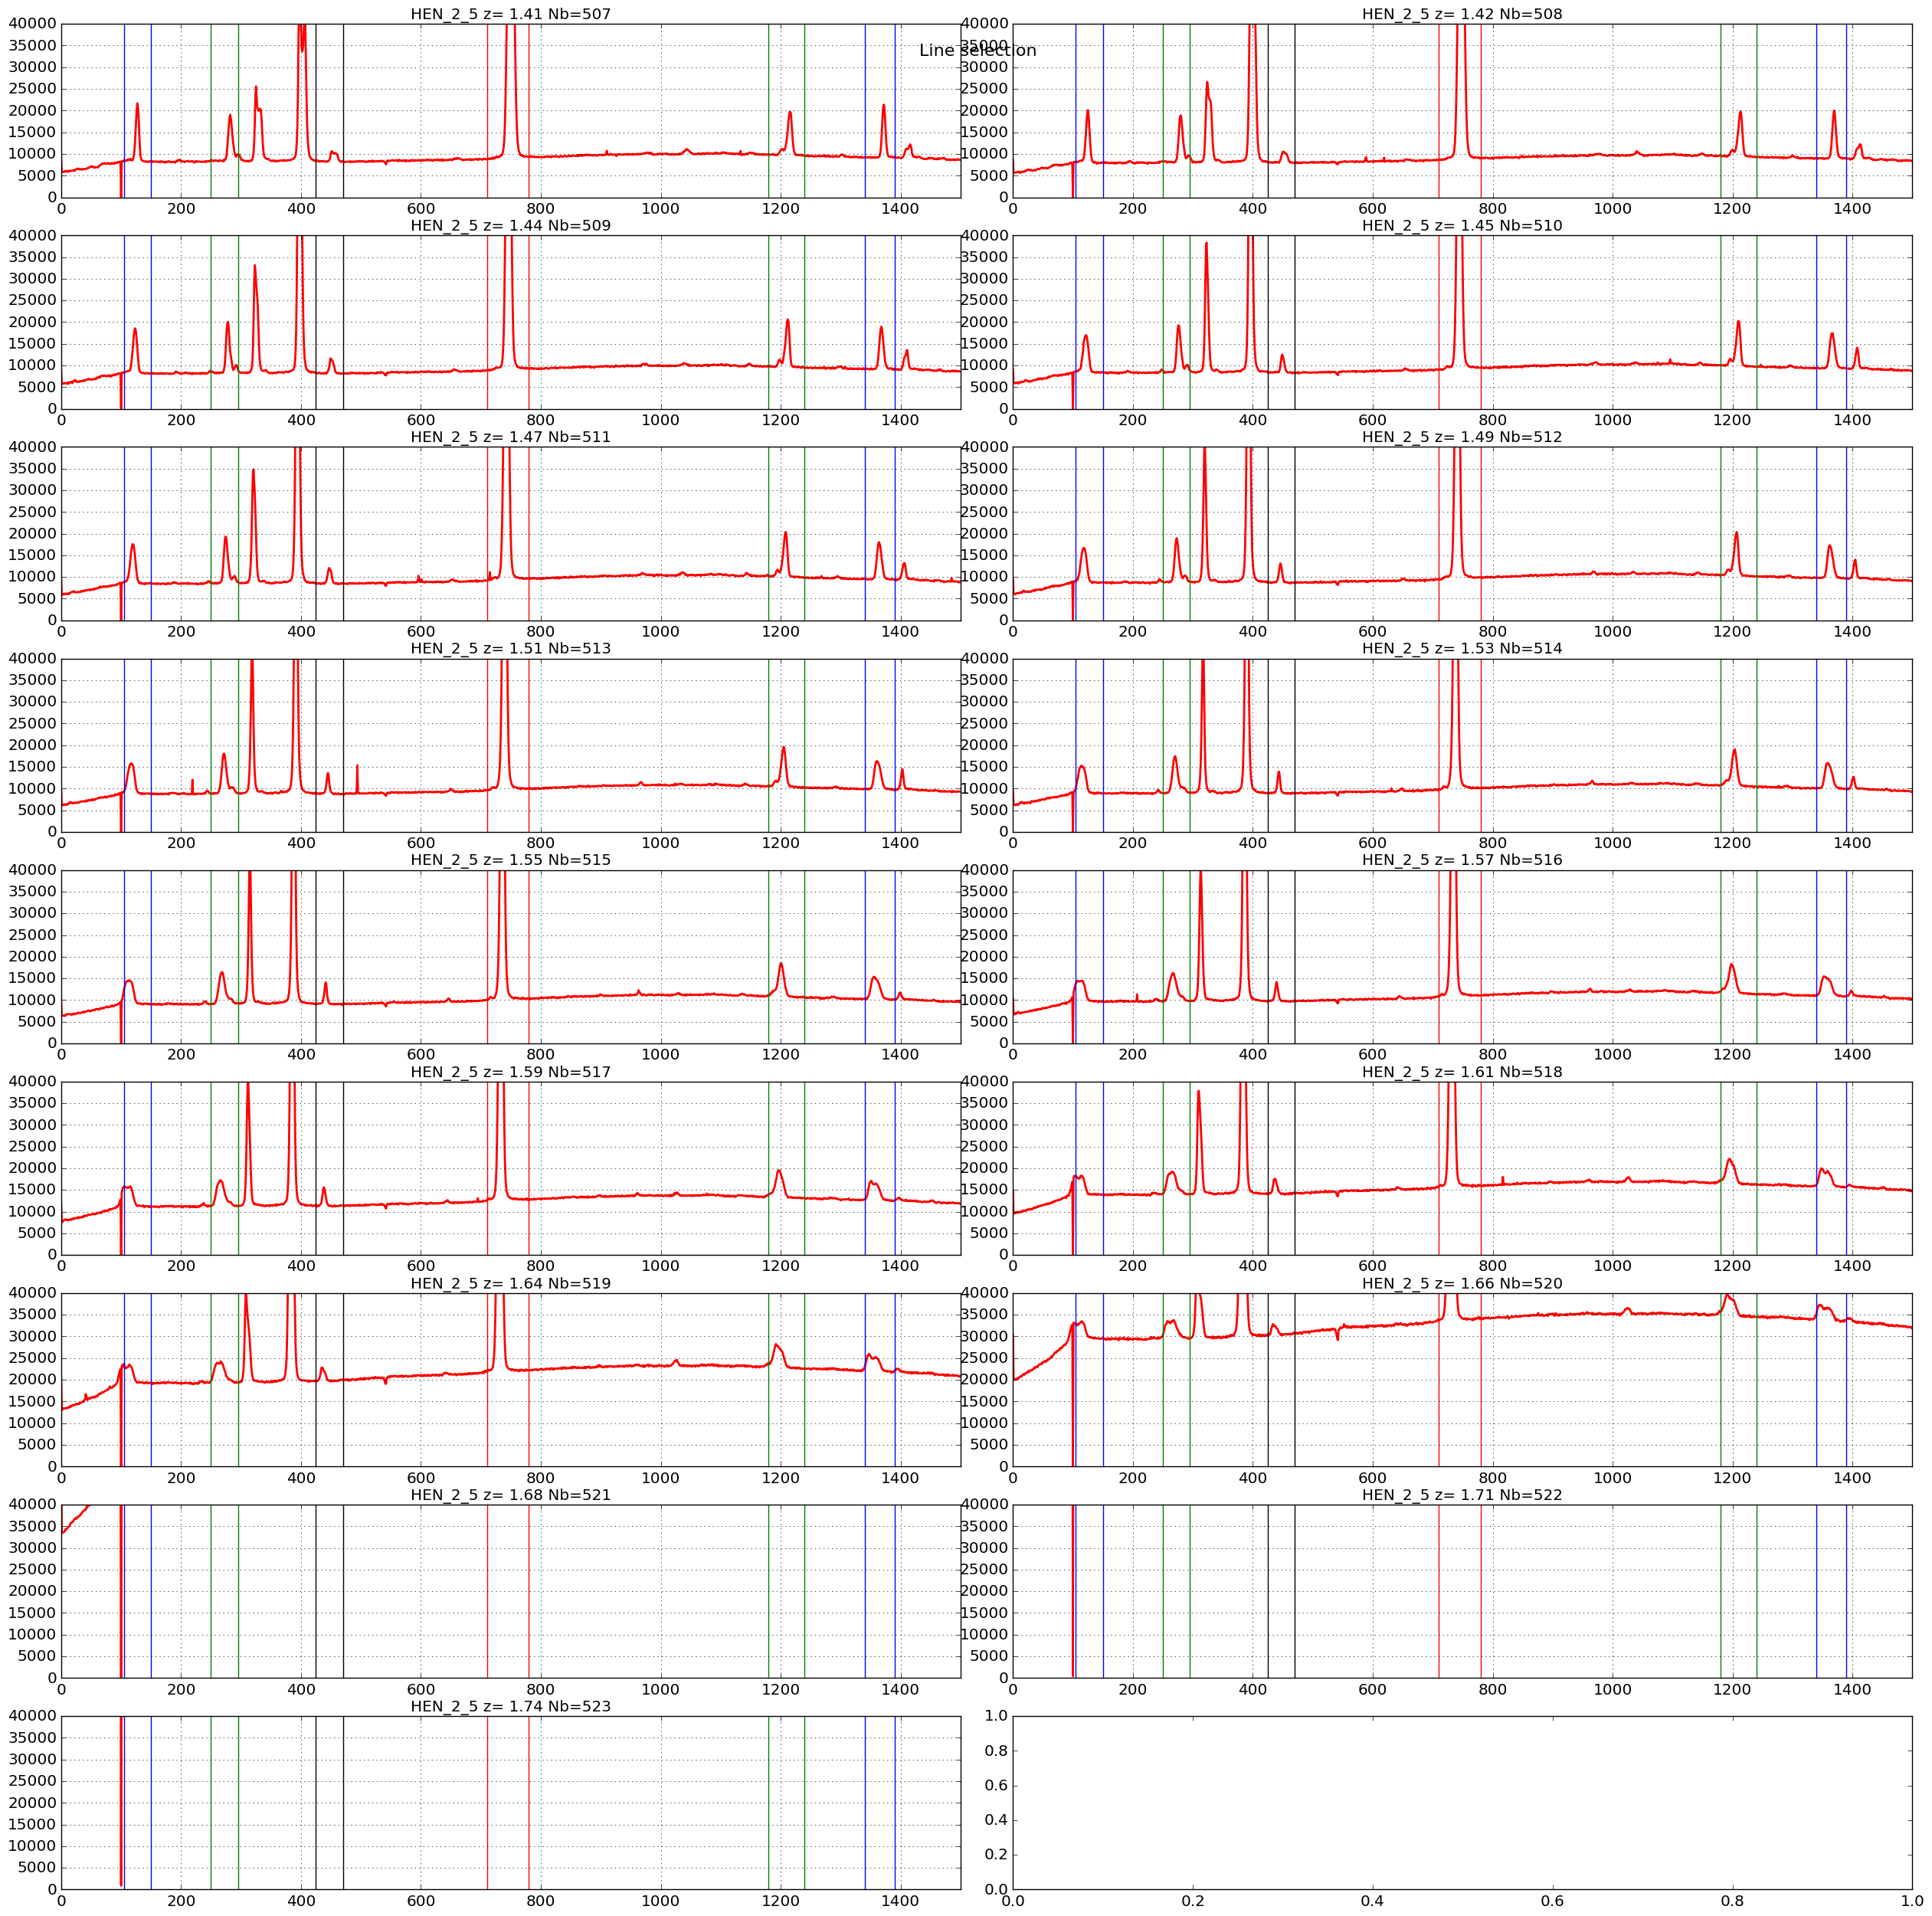

In [58]:
eline1,eline2,eline3,eline4,eline5=SelectLines(all_spectra,all_titles,object_name,dir_top_images,'selectlines.pdf')

In [59]:
def GetMaxAndWidth(spectrum):
    themax=spectrum.max()
    themean,therms=weighted_avg_and_std(np.arange(spectrum.shape[0]), np.abs(spectrum))
    return themax,therms

In [60]:
def SubtractBackground(spectrum):
    Nsize=spectrum.shape[0]
    Dleft=5
    Dright=5
    
    xleft=np.arange(0,Dleft)
    yleft=spectrum[0:Dleft]
    xright=np.arange(Nsize-Dright,Nsize)
    yright=spectrum[Nsize-Dright:Nsize]
    
    xbg=np.concatenate([xleft,xright])
    ybg=np.concatenate([yleft,yright])
    
    z = np.polyfit(xbg, ybg, 1)
    p = np.poly1d(z)
        
    xfit=np.arange(0,Nsize)
    yfit=p(xfit)
    
    cleanspec=spectrum-yfit
    
    #plt.plot(cleanspec)
    
    #plt.grid(True)    
    return cleanspec    

In [61]:
def CleanAllLines(line_set):
    cline_set=[]
    for line in line_set:
        cline=SubtractBackground(line)
        cline_set.append(cline)
    return cline_set

In [62]:
def AllMaxAndWidth(line_set):
    the_max = []
    the_rms = []
    index=0
    indexmax=11
    for line in line_set:
        index+=1
        if index<indexmax: 
            themax,therms = GetMaxAndWidth(line)
            the_max.append(themax)
            the_rms.append(therms)
    return the_max,the_rms

In [63]:
cline1=CleanAllLines(eline1)
cline2=CleanAllLines(eline2)
cline3=CleanAllLines(eline3)
cline4=CleanAllLines(eline4)
cline5=CleanAllLines(eline5)

In [64]:
themax1,therms1= AllMaxAndWidth(cline1)

In [65]:
themax2,therms2= AllMaxAndWidth(cline2)

In [66]:
themax3,therms3= AllMaxAndWidth(cline3)

In [67]:
themax4,therms4= AllMaxAndWidth(cline4)

In [68]:
themax5,therms5= AllMaxAndWidth(cline5)

In [69]:
N=len(themax1)

In [70]:
thefoc=Focus[0:N]

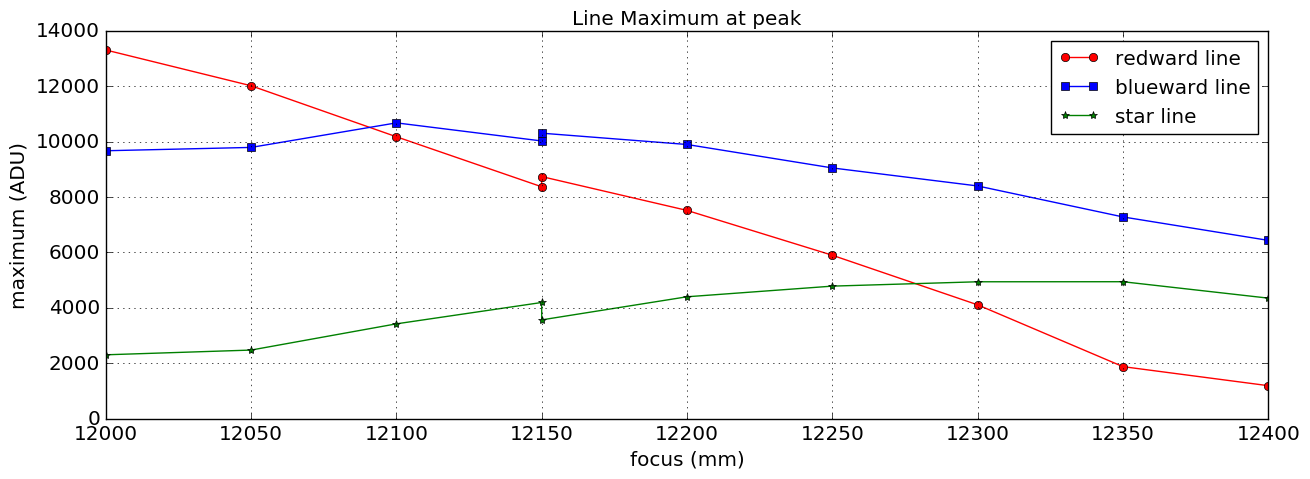

In [71]:
plt.figure(figsize=(15,5))
plt.plot(thefoc,themax1,'o-',color='red',label='redward line')
plt.plot(thefoc,themax2,'s-',color='blue',label='blueward line')
plt.plot(thefoc,themax5,'*-',color='green',label='star line')
plt.grid(True)
plt.title('Line Maximum at peak')
plt.ylabel('maximum (ADU)')
plt.xlabel('focus (mm)')
plt.legend(loc='best')

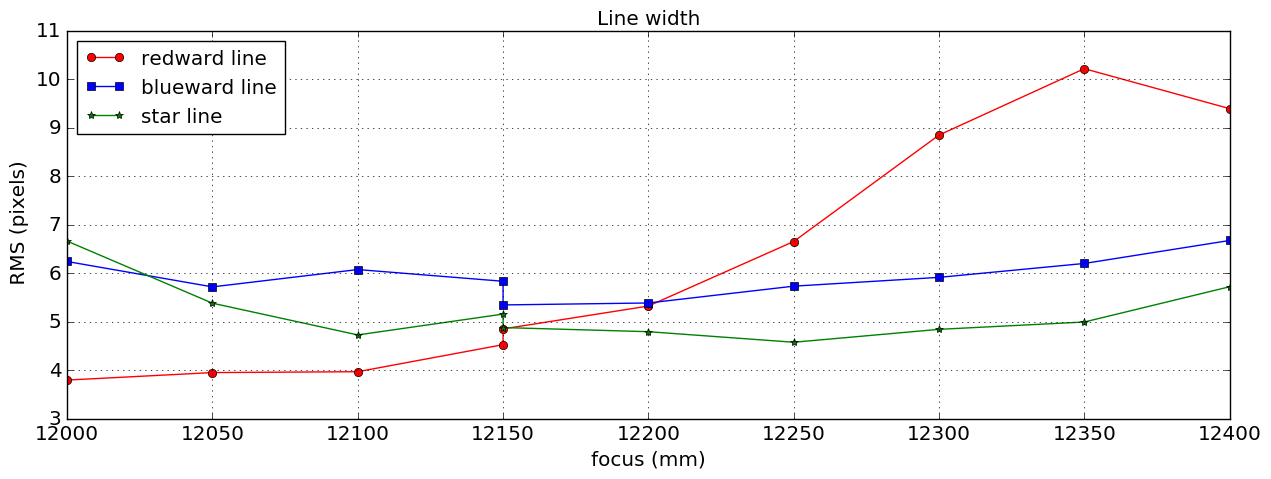

In [72]:
plt.figure(figsize=(15,5))
plt.plot(thefoc,therms1,'o-',color='red',label='redward line')
plt.plot(thefoc,therms2,'s-',color='blue',label='blueward line')
plt.plot(thefoc,therms5,'*-',color='green',label='star line')
plt.grid(True)
plt.title('Line width')
plt.ylabel(' RMS (pixels)')
plt.xlabel('focus (mm)')
plt.legend(loc='best')

In [73]:
def PlotLineShapes(cline,thetitle):
    index=0
    indexmax=11

    for line in cline:
        index+=1
        if(index<indexmax):        
            plt.plot(line)
    plt.ylim(0,15000)
    plt.grid(True)
    plt.title(thetitle)
    plt.xlabel('pixel')
    plt.ylabel('Line Instensity')

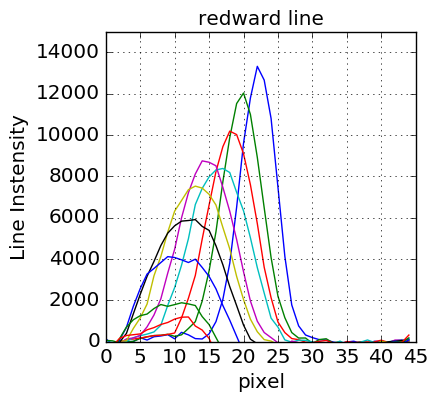

In [74]:
PlotLineShapes(cline1,'redward line')

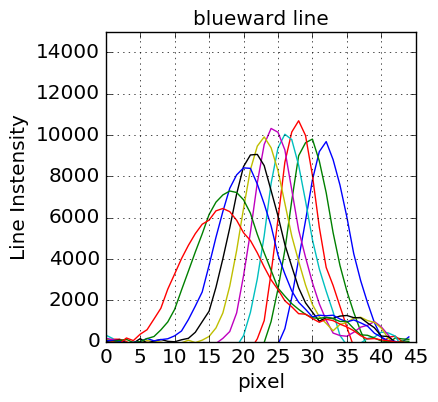

In [75]:
PlotLineShapes(cline2,'blueward line')

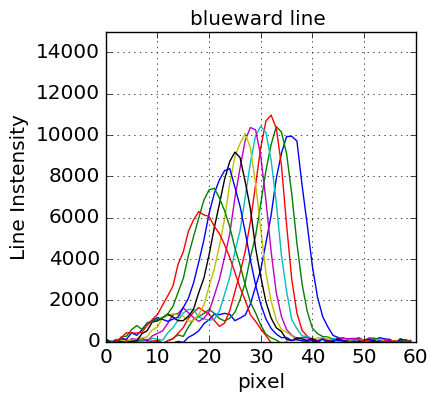

In [76]:
PlotLineShapes(cline3,'blueward line ')

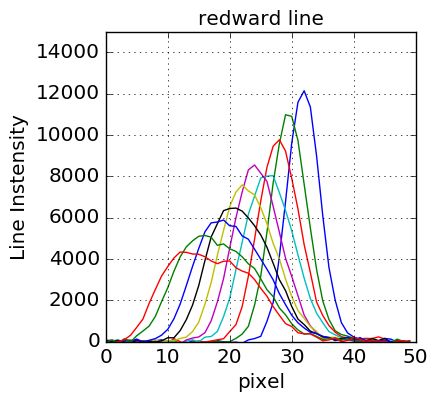

In [77]:
PlotLineShapes(cline4,'redward line')

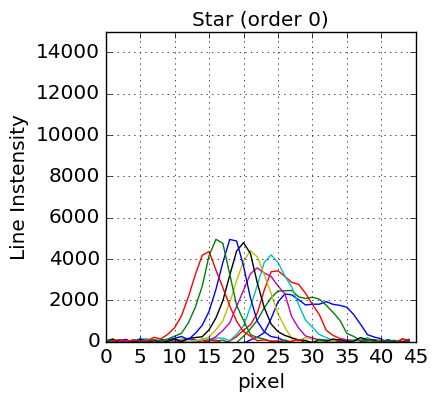

In [78]:
PlotLineShapes(cline5,'Star (order 0)')

In [124]:
6*1.32

7.92

In [125]:
500/10

50